## Getting Started

- Download MapPLUTO data from [NYC DCP](https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_mappluto_24v1_1_shp.zip)
- Unzip the file and place contents in the `Data` directory at the root of this repo
- Make sure you have installed all requisite libraries by running `pip install -r requirements.txt` **_with your virtual environment activated_**

## Goals

- Load data from file
- Explore spatial and non-spatial elements of the dataset
- Compare tradeoffs between different methods of loading data
- Demonstrate tradeoffs in different file formats


In [1]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk 

# load PLUTO data


In [2]:
# pluto = gpd.read_file("../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

In [4]:
pluto_ogrio = ogr.read_dataframe("../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

# basic exploration


In [4]:
pluto_ogrio.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [5]:
pluto_ogrio.dtypes

Borough         object
Block            int64
Lot              int32
CD               int32
BCT2020         object
                ...   
Longitude      float64
Notes           object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
Length: 95, dtype: object

## categorical column


In [6]:
pluto_ogrio.LandUse.value_counts()

LandUse
01    565933
02    131623
04     55966
11     24904
05     21260
03     12916
08     12052
06      9431
10      9344
07      6033
09      4708
Name: count, dtype: int64

🧐 What do those numbers mean? Let's look at the [data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf)


In [7]:
# now we can remap the numbers into something more meaningful

land_use_codes = {
    "01": "One & Two Family Buildings",
    "02": "Multi-Family Walk-Up Buildings",
    "03": "Multi-Family Elevator Buildings",
    "04": "Mixed Residential & Commercial Buildings",
    "05": "Commercial & Office Buildings",
    "06": "Industrial & Manufacturing",
    "07": "Transportation & Utility",
    "08": "Public Facilities & Institutions",
    "09": "Open Space & Outdoor Recreation",
    "10": "Parking Facilities",
    "11": "Vacant Land",
}

In [8]:
pluto_ogrio["LandUse"] = pluto_ogrio.LandUse.map(land_use_codes)

## Your turn:

- How many lots of each land use type are there?
  - Use `groupby` to determine the number of lots of each land use type
- What is the lot area of each land use type?
  - Use `groupby` to make a bar chart that shows the average lot area of each land use type
- Can you find the total number of lots that contain `Commercial & Office Buildings` in the Bronx?
  - use groupby on multiple columns to achieve this
- Can you find the share of each land use type in each borough?


LandUse
Commercial & Office Buildings                21260
Industrial & Manufacturing                    9431
Mixed Residential & Commercial Buildings     55966
Multi-Family Elevator Buildings              12916
Multi-Family Walk-Up Buildings              131623
One & Two Family Buildings                  565933
Open Space & Outdoor Recreation               4708
Parking Facilities                            9344
Public Facilities & Institutions             12052
Transportation & Utility                      6033
Vacant Land                                  24904
dtype: int64


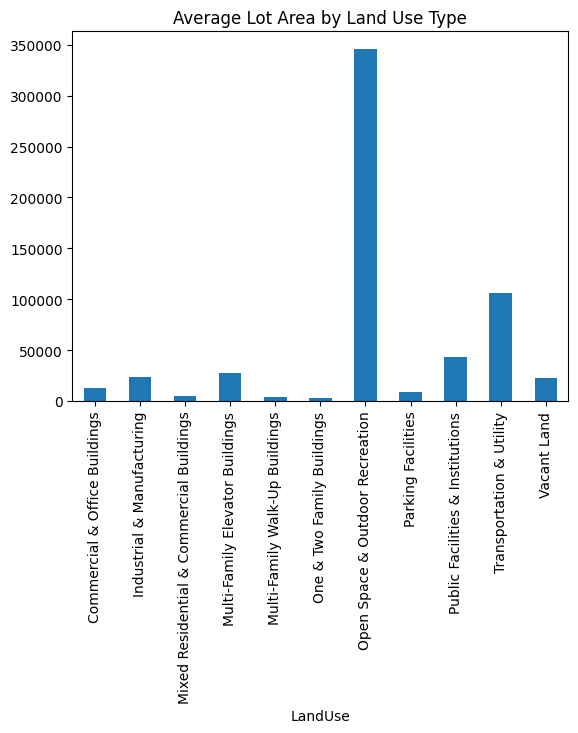

Total Commercial & Office Buildings in the Bronx: 2886
Borough  LandUse                                 
BK       Commercial & Office Buildings               0.020274
         Industrial & Manufacturing                  0.014530
         Mixed Residential & Commercial Buildings    0.089415
         Multi-Family Elevator Buildings             0.013174
         Multi-Family Walk-Up Buildings              0.236337
         One & Two Family Buildings                  0.564920
         Open Space & Outdoor Recreation             0.004440
         Parking Facilities                          0.010880
         Public Facilities & Institutions            0.015305
         Transportation & Utility                    0.006480
         Vacant Land                                 0.019767
BX       Commercial & Office Buildings               0.032299
         Industrial & Manufacturing                  0.013799
         Mixed Residential & Commercial Buildings    0.048717
         Multi-Family Eleva

In [12]:
lots_count = pluto_ogrio.groupby("LandUse").size()
print(lots_count)

avg_lot_area = pluto_ogrio.groupby("LandUse").LotArea.mean()
avg_lot_area.plot.bar()
plt.title("Average Lot Area by Land Use Type")
plt.show()

bronx_commercial = pluto_ogrio[(pluto_ogrio.Borough == "BX") & (pluto_ogrio.LandUse == "Commercial & Office Buildings")].shape[0]
print(f"Total Commercial & Office Buildings in the Bronx: {bronx_commercial}")

borough_land_use_share = pluto_ogrio.groupby(["Borough", "LandUse"]).size() / pluto_ogrio.groupby("Borough").size()
print(borough_land_use_share)



## Okay, now let's look at lot and building area


Text(0.5, 1.0, 'Total lot area by land use type')

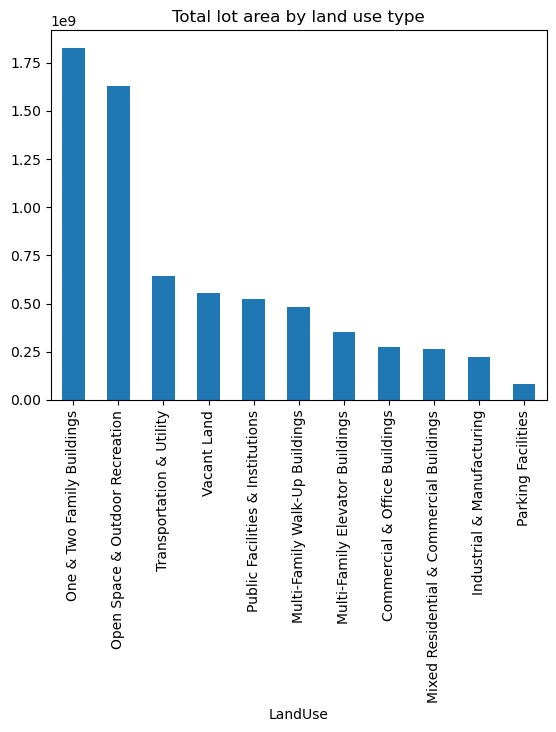

In [9]:
pluto_ogrio.groupby("LandUse").LotArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total lot area by land use type")

Text(0.5, 1.0, 'Total building area by land use type')

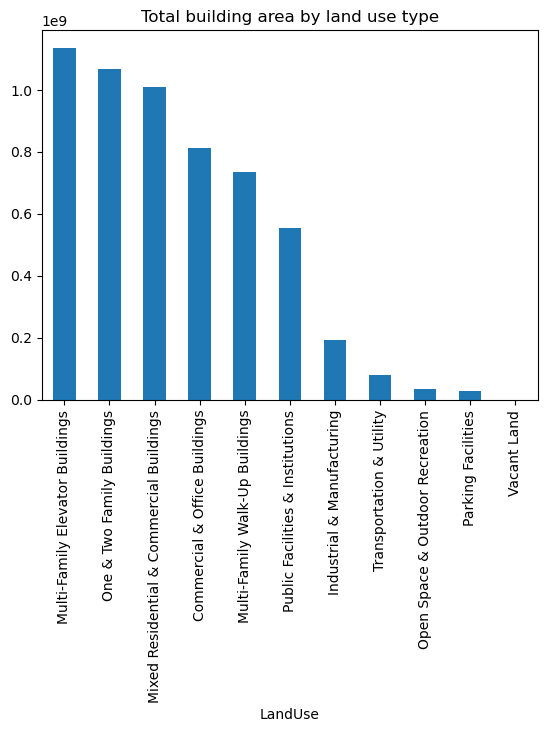

In [10]:
# now the same but for building area
pluto_ogrio.groupby("LandUse").BldgArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total building area by land use type")

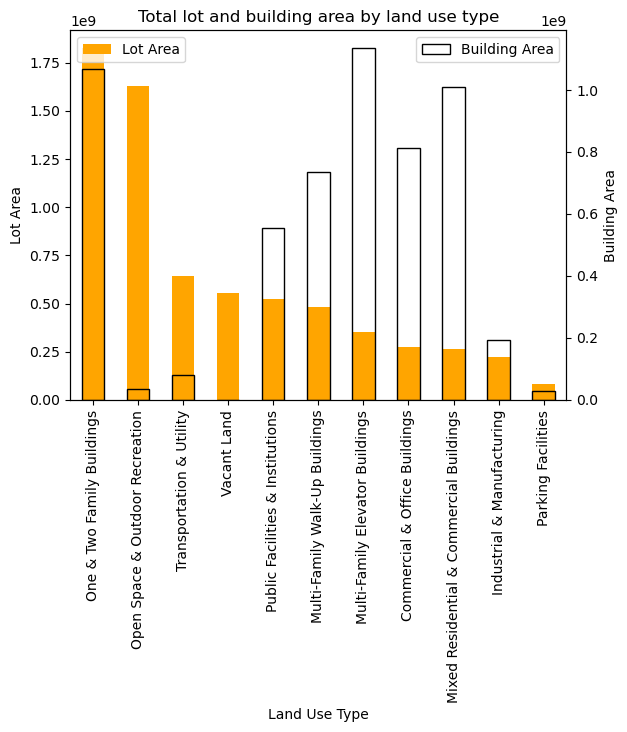

In [11]:
# plot both lot and building area on the same plot with a secondary y-axis
fig, ax = plt.subplots()
by_lot_area = pluto_ogrio.groupby("LandUse").LotArea.sum().sort_values(ascending=False)

by_lot_area.plot.bar(ax=ax, color="orange")

# get order to apply below
order = {v: i for i, v in enumerate(by_lot_area.index)}

ax.set_ylabel("Lot Area")
ax.set_xlabel("Land Use Type")

ax2 = ax.twinx()
pluto_ogrio.groupby("LandUse").BldgArea.sum().reindex(by_lot_area.index).plot.bar(
    ax=ax2, edgecolor="black", color="none"
)
ax2.set_ylabel("Building Area")

plt.title("Total lot and building area by land use type")

# add legends
ax.legend(["Lot Area"], loc="upper left")
ax2.legend(["Building Area"], loc="upper right")

## numeric column


In [12]:
pluto_ogrio["NumFloors"].describe()

count    856819.000000
mean          2.357554
std           2.012707
min           0.000000
25%           2.000000
50%           2.000000
75%           2.500000
max         104.000000
Name: NumFloors, dtype: float64

<Axes: ylabel='Frequency'>

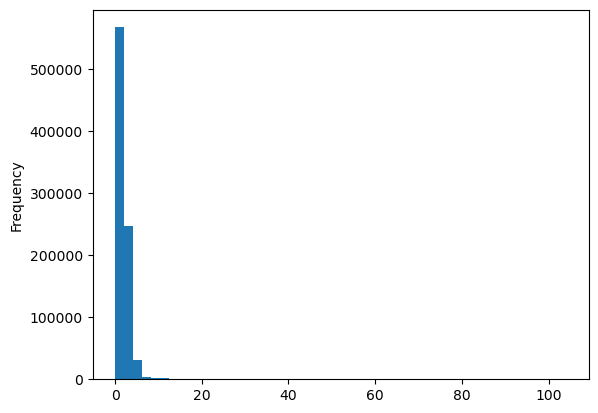

In [13]:
pluto_ogrio["NumFloors"].plot.hist(bins=50)

## Your turn:

- make a histogram for each borough like above
- then, choose another chart type to visualize the distribution of lot area for each borough. See [here](https://matplotlib.org/stable/plot_types/index.html) for some built in options in matplotlib, or here for [seaborn](https://seaborn.pydata.org/tutorial/distributions.html)


## Ok, now let's make a boxplot to see how wide the range is within each boro's data


<Axes: title={'center': 'NumFloors'}, xlabel='Borough'>

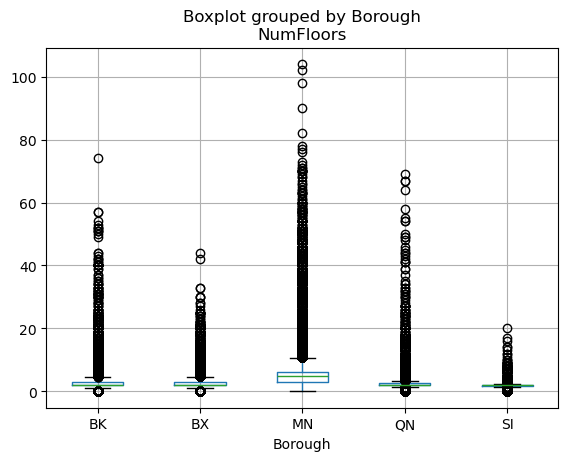

In [14]:
pluto_ogrio.boxplot(column="NumFloors", by="Borough")

What does this distribution tell us about the number of floors in each borough?


# cluster by number of floors


In [15]:
# get clusters using kmeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(pluto_ogrio[["NumFloors", "ResArea"]])

pluto_ogrio["NumFloorsCluster"] = kmeans.predict(pluto_ogrio[["NumFloors", "ResArea"]])

In [16]:
pluto_ogrio.groupby("NumFloorsCluster").NumFloors.describe().sort_values("max")

,count,mean,std,min,25%,50%,75%,max
NumFloorsCluster,,,,,,,,
3,3.0,20.000000,11.269428,13.0,13.5,14.0,23.5,33.0
2,35.0,18.985714,11.616726,0.0,13.5,18.0,24.5,46.0
4,8450.0,9.935355,7.257568,0.0,6.0,6.0,13.0,82.0
1,861.0,23.599303,15.800584,0.0,13.0,20.0,33.0,98.0
0,847470.0,2.259667,1.502801,0.0,2.0,2.0,2.5,104.0


<Axes: xlabel='NumFloors', ylabel='ResArea'>

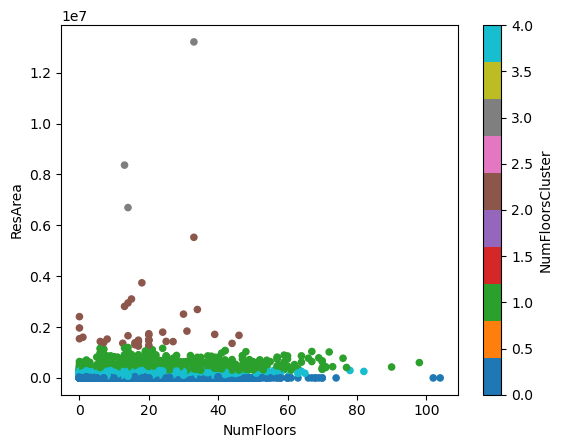

In [17]:
pluto_ogrio.plot.scatter(x="NumFloors", y="ResArea", c="NumFloorsCluster", cmap="tab10")

<Axes: xlabel='NumFloors', ylabel='ResArea'>

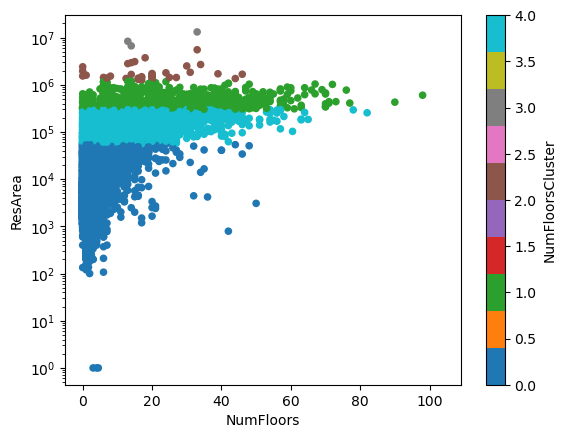

In [18]:
# same as above but with log y axis
pluto_ogrio.plot.scatter(
    x="NumFloors", y="ResArea", c="NumFloorsCluster", cmap="tab10", logy=True
)

<Axes: ylabel='Frequency'>

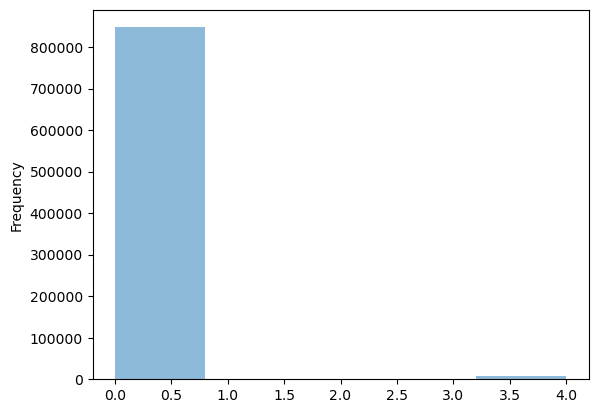

In [19]:
pluto_ogrio["NumFloorsCluster"].plot.hist(bins=5, alpha=0.5)

# and now, mapping


## static map


Text(0.5, 1.0, 'NYC MapPLUTO')

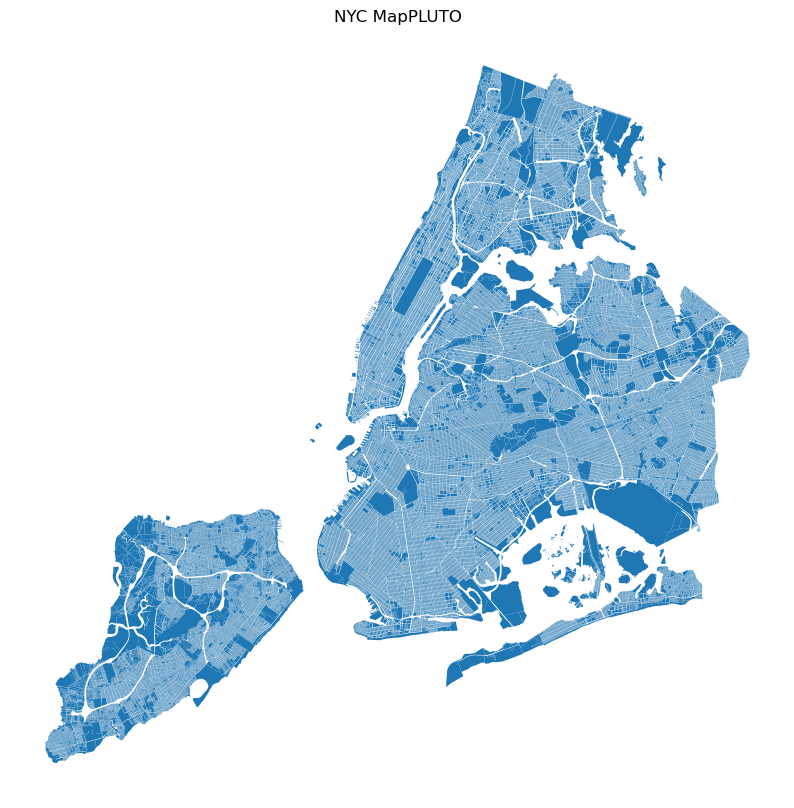

In [20]:
pluto_ogrio.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC MapPLUTO")

In [21]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [22]:
pluto_ogrio.fillna({"LandUse": "Unknown"}, inplace=True)

In [23]:
pluto_ogrio["color"] = pluto_ogrio["LandUse"].map(cmap)

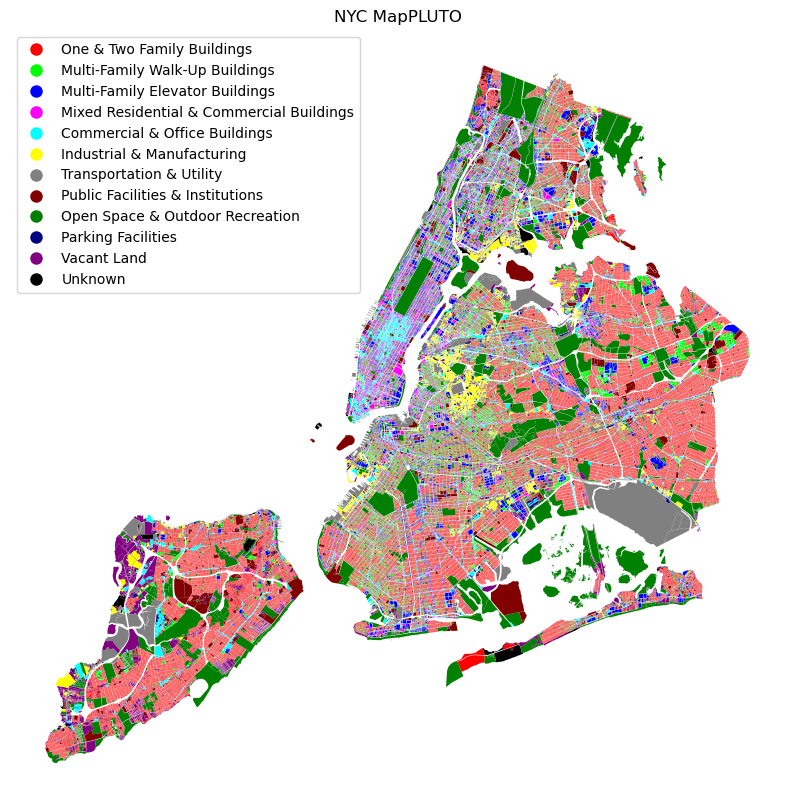

In [24]:
ax = pluto_ogrio.plot(
    color=pluto_ogrio["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC MapPLUTO")


# populate legend items based on dict from above
legend_colors = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

Text(0.5, 1.0, 'NYC MapPLUTO')

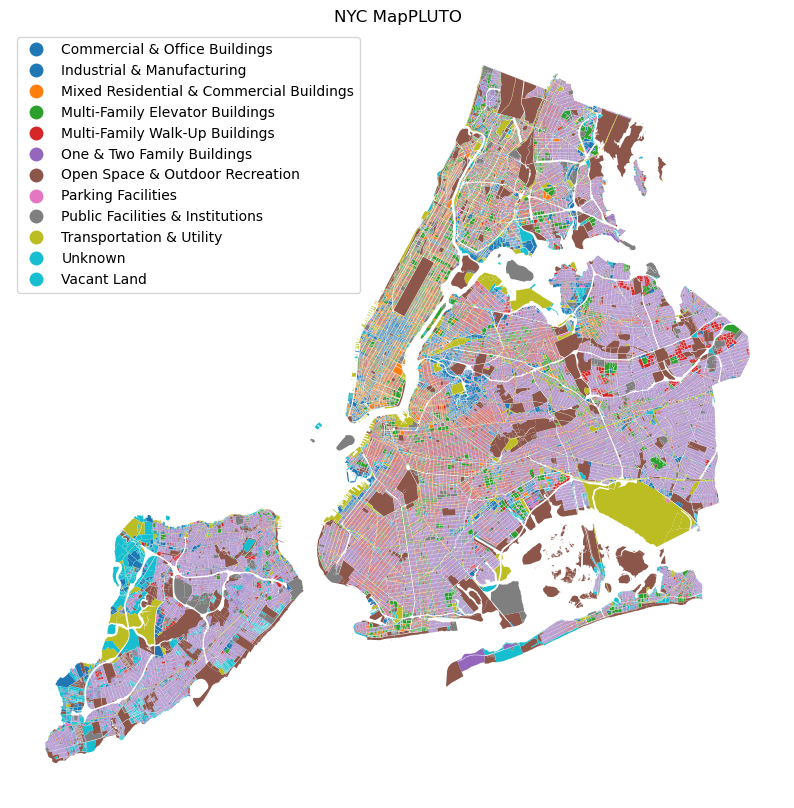

In [25]:
pluto_ogrio.plot(
    column="LandUse", figsize=(10, 10), legend=True, legend_kwds={"loc": "upper left"}
).set_axis_off()
plt.title("NYC MapPLUTO")

## Your turn:

- map a numeric column using a continuous colormap for Queens. See here for a list and discussion of colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
- What patterns emerge?


# prep for interactive mapping


In [14]:
pluto_ogrio_wgs = pluto_ogrio.to_crs("epsg:4326")

## visualize a categorical variable


In [21]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

In [22]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [23]:
len(pluto_ogrio_wgs[pluto_ogrio_wgs["LandUse"].isna()])

0

In [24]:
pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)

## uhoh- observe the above warning- re-write the code to avoid this


## now, we can plot the data using lonboard to create an interactive map


In [25]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x17e37c700>
[
  [
    128,
…

In [26]:
pluto_ogrio_wgs["LandUse"] = pluto_ogrio_wgs["LandUse"].astype("category")

In [27]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x2ccdceec0>
[
  [
    128,
…

In [29]:
pluto_ogrio_wgs[pluto_ogrio_wgs.geometry.isna()]

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,FIRM07_FLA,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry


## visualize a continuous variable


In [48]:
df = pluto_ogrio_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
    get_elevation=df["NumFloors"] * 14,
    extruded=True
)
m = Map(layer)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x2f03b3880>
[
  49,
 …

## your turn: can you make the above show in 3d?

- see here for some tips: https://developmentseed.org/lonboard/latest/examples/overture-maps/#imports


ValueError: pyarrow._fs.LocalFileSystem size changed, may indicate binary incompatibility. Expected 64 from C header, got 56 from PyObject

# save data


In [36]:
# save out as fgb using geopandas
# pluto_ogrio.to_file("..Data/nyc_mappluto_24v1_1_shp/mappluto.fgb")

In [37]:
# ogr.write_dataframe(pluto_ogrio, "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb")